In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import photRM # credits Dr Anđelka Kovačević & Isidora Jankov (https://github.com/LSST-sersag/dle)
from rm_utils import ZDCF, load_results_ZDCF, PLIKE # functions to wrap fortran programs
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# hopefully this command returns a no input files error
! gfortran

# otherwise you'll need to run the command 
#   ---> brew install gcc

gfortran: fatal error: no input files
compilation terminated.


## Compile the fortran programs if they aren't already

In [9]:
FORTRAN_DIR = 'fortran_dir'
os.chdir(FORTRAN_DIR)
! gfortran zdcf_v2.2.f90 -o zdcf
! gfortran plike_v4.0.f90 -o plike
os.chdir('../')

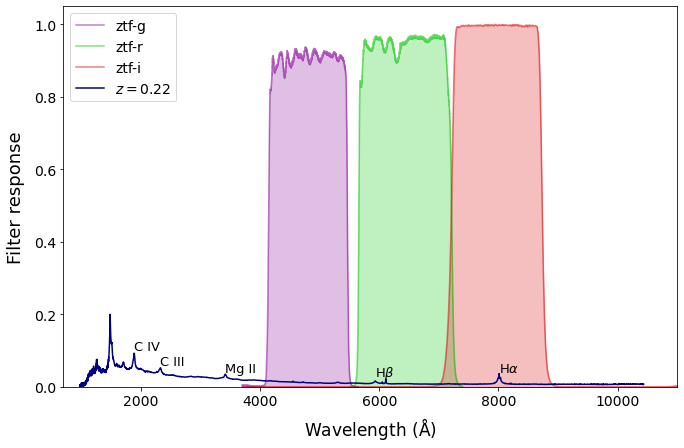

In [3]:
photRM.filters_viz(z=0.22, phot_sys='ZTF', save=True)

In [89]:
import csv

In [101]:
os.chdir('..')

In [141]:
%autoreload

- **<font color='violet'> $g$-band covers continuum </font>**
- **<font color='#0AD304'>$r$-band covers Hb and continuum </font>**
- **<font color='indianred'> $i$-band covers Ha and continuum </font>**

We choose **g band** for pure continuum light curve (X-band) and **r band** for continuum + line light curve (Y-band).

**Note:** i-band light curves usually have much lower number of points compared to g and r bands, which is the reason for not considering it in this analysis.

## Averaging duplicates in the light curves

In [126]:
# B,G,V,R,I,Z

B = '3C273_Bband_truncated_detrended_1st-order_new.dat'
G = '3C273_Gband_truncated_detrended_1st-order_new.dat'
V = '3C273_Vband_truncated_detrended_1st-order_new.dat'
R = '3C273_Rband_truncated_detrended_1st-order_new.dat'
I = '3C273_Iband_truncated_detrended_1st-order_new.dat'
Z = '3C273_Zband_truncated_detrended_1st-order_new.dat'

os.chdir('./fortran_dir')
## averaging duplicates in the light curves and saving them again
B_df = pd.read_csv(B, sep=' ', header=None)
B_df = B_df.groupby(0).mean().reset_index()
B_df.to_csv(B, sep='\t', header=False, index=False)
#################
G_df = pd.read_csv(G, sep=' ', header=None)
G_df = G_df.groupby(0).mean().reset_index()
G_df.to_csv(G, sep='\t', header=False, index=False)
#################
V_df = pd.read_csv(V, sep=' ', header=None)
G_df = V_df.groupby(0).mean().reset_index()
V_df.to_csv(V, sep='\t', header=False, index=False)
#################
R_df = pd.read_csv(R, sep=' ', header=None)
R_df = R_df.groupby(0).mean().reset_index()
R_df.to_csv(R, sep='\t', header=False, index=False)
#################
I_df = pd.read_csv(I, sep=' ', header=None)
I_df = I_df.groupby(0).mean().reset_index()
I_df.to_csv(I, sep='\t', header=False, index=False)
#################
Z_df = pd.read_csv(Z, sep=' ', header=None)
Z_df = Z_df.groupby(0).mean().reset_index()
Z_df.to_csv(Z, sep='\t', header=False, index=False)

os.chdir('..')

In [142]:
# autocorrelation function w/ continuum
ZDCF(B, B, 'acf_3c273', acf=True)
# ccf w/ continuum and other bands
ZDCF(B,G, 'ccf_bg_3c273')
ZDCF(B,V, 'ccf_bv_3c273')
ZDCF(B,R, 'ccf_br_3c273')
ZDCF(B,I, 'ccf_bi_3c273')
ZDCF(B,Z, 'ccf_bz_3c273')

ZDCF V2.2 begins:
Auto-correlation or cross-correlation? (1/2):
Enter output files prefix:
Uniform sampling of light curve? (y/n):
Enter minimal number of points per bin (0 for default):
Omit zero-lag points? (y/n):
How many Monte Carlo runs for error estimation?

ZDCF PARAMETERS:
Autocorrelation?  F
Uniform sampling? F
Omit zero lags?   T
Minimal # in bin:         11
# of Monte Carlo:        100
Monte Carlo seed:     123456
Enter name of 1st light curve file:
Enter name of 2nd light curve file:
ZDCF V2.2 begins:
Auto-correlation or cross-correlation? (1/2):
Enter output files prefix:
Uniform sampling of light curve? (y/n):
Enter minimal number of points per bin (0 for default):
Omit zero-lag points? (y/n):
How many Monte Carlo runs for error estimation?

ZDCF PARAMETERS:
Autocorrelation?  F
Uniform sampling? F
Omit zero lags?   T
Minimal # in bin:         11
# of Monte Carlo:        100
Monte Carlo seed:     123456
Enter name of 1st light curve file:
Enter name of 2nd light curve file

At line 948 of file zdcf_v2.2.f90 (unit = 5, file = 'stdin')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10117f187
#1  0x10117fd37
#2  0x101180613
#3  0x101269dc3
#4  0x101263e9f
#5  0x10126482f
#6  0x100c8789f
#7  0x100c8a55b


2  5.135E-01  1.105E+00  6.697E-02  2.153E-01  2.121E-01 (  24)
  2.060E+02  3.385E-01  5.727E-01  4.054E-02  2.153E-01  2.134E-01 (  24)
  2.077E+02  2.713E-01  8.748E-01  3.016E-01  1.926E-01  1.806E-01 (  26)
  2.097E+02  2.736E-01  5.925E-01  4.328E-01  2.031E-01  1.824E-01 (  20)
  2.113E+02  2.418E-01  6.479E-01  3.086E-01  2.767E-01  2.510E-01 (  14)
  2.125E+02  2.292E-01  7.414E-01 -7.093E-02  2.486E-01  2.534E-01 (  18)
  2.141E+02  4.865E-01  5.154E-01  7.510E-01  1.288E-01  1.047E-01 (  16)
  2.155E+02  1.446E-01  8.961E-02 -3.065E-01  2.743E-01  3.054E-01 (  12)
  2.170E+02  5.122E-01  1.004E+00  7.808E-01  1.259E-01  9.972E-02 (  14)
  2.190E+02  3.709E-01  6.237E-01 -2.953E-01  2.769E-01  3.071E-01 (  12)
  2.206E+02  2.757E-01  9.537E-01 -2.605E-01  2.846E-01  3.119E-01 (  12)
  2.229E+02  6.136E-01  6.781E-01 -2.226E-01  2.482E-01  2.647E-01 (  16)
  2.257E+02  1.108E+00  1.798E+00 -4.017E-01  2.290E-01  2.597E-01 (  14)
  2.287E+02  4.383E-01  1.556E+01  8.814E-01  9.

## ZDCF saves results as ___.dcf

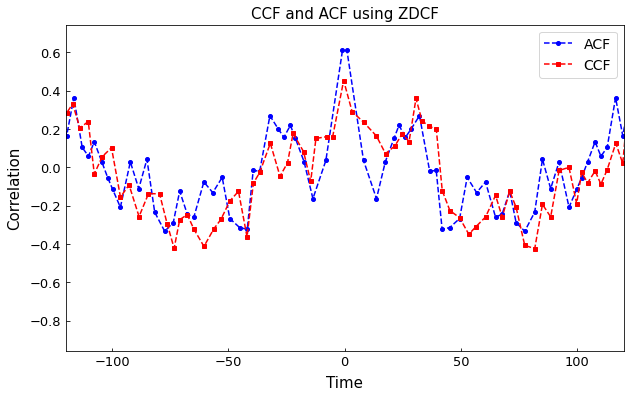

In [156]:
acf, ccf = load_results_ZDCF('acf_3c273.dcf', 'ccf_bg_3c273.dcf', fortran_dir='fortran_dir', plot=True)

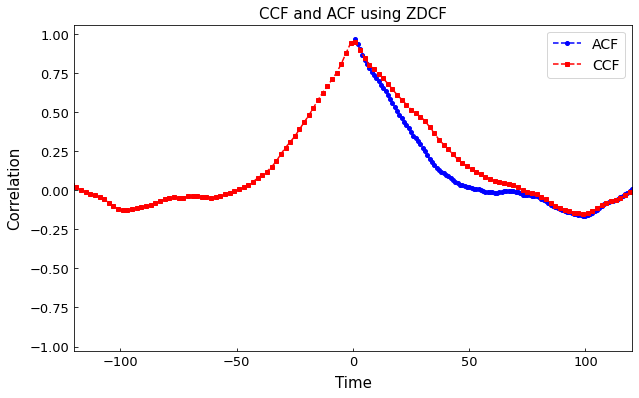

In [146]:
acf, ccf = load_results_ZDCF('tutorial_sim_acf.dcf', 'tutorial_sim_ccf.dcf', fortran_dir='fortran_dir', plot=True)

In [157]:
# since ZDCF does not provide the ACF on the negative tau axis, we need to add it:
acf_total = photRM.add_inverted_acf(acf)
print(acf_total.shape)
print(ccf.shape)
# We still need to make CCF and ACF the same length so we could subtract them.
# We do this by interpolating one of those functions to the time grid of the other.
acf_interp = photRM.interp(ccf, acf_total) # first param is the function having the x-axis on which we want to interpolate the other function.
print(acf_interp.shape)
print(ccf.shape)
# Subtracting CCF and ACF
final_ccf = photRM.delta_ccf(acf_interp, ccf)
final_ccf.to_csv('fortran_dir/plike_bg_3c273.dcf', sep=" ", index=False, header=False)
final_ccf.tail()
photRM.plot_ccf_acf(final_ccf, ccf, acf_interp, locator=10)

(340, 7)
(175, 7)


ValueError: Expect x to not have duplicates

In [59]:
PLIKE('plike_input_sim.dcf', 0,100) # will print results? make sure to sanity check the estimated lags

PLIKE V4.0 begins.
Enter dcf file name:
Enter lower bound on peak location:
Enter upper bound on peak location:

Calculating ML in range t_lag =  0.000E+00 to  1.000E+02

  50 data points found in time-lag range

ZDCF peak at  +3.300E+01 r_max =  +2.057E-01 ZDCF C.O.M. at  +3.595E+01

Progress meter: ................................................

Results:

# PLIKE V4.0 ZDCF peak likelihood analysis
# for file plike_input_sim.dcf
#
# num      lag         r         -dr        +dr    likelihood 
# ---- ---------- ---------- ---------- ---------- ---------- 
     1  1.000E+00 -1.543E-02  3.718E-03  3.636E-03  0.000E+00
     2  3.000E+00 -2.267E-03  8.361E-03  8.193E-03  0.000E+00
     3  5.000E+00  1.090E-02  1.308E-02  1.284E-02  8.013E-11
     4  7.000E+00  2.308E-02  1.684E-02  1.654E-02  7.644E-10
     5  9.000E+00  3.467E-02  1.935E-02  1.903E-02  5.802E-09
     6  1.100E+01  4.706E-02  2.180E-02  2.145E-02  4.449E-08
     7  1.300E+01  5.986E-02  2.403E-02  2.366E-02  3.181E-07
  

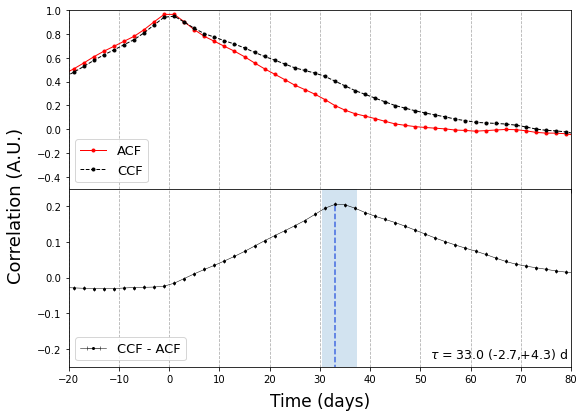

In [60]:
# PLIKE results:
tau = 33
err_low = -2.66
err_high = 4.35
photRM.plot_ccf_acf(final_ccf, ccf, acf_interp, locator=10, peak=True, tau=tau, err_low=err_low, err_high=err_high, x1=-20, x2=80, y1=-0.5, y2=1)